In [62]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from aesara import tensor as at
from bokeh.io import output_notebook, show
# from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import pysindy as ps
from pydmd import DMD
import glob
import pandas as pd

CPP_Data_Dir = "/home/arch/Documents/Bernoulli_Network_Optimal_Control/Cpp/data/"
CPP_Figure_Dir = "/home/arch/Documents/Bernoulli_Network_Optimal_Control/Cpp/figures/"

def load_SIR_trajectories():
    trajs = glob.glob(CPP_Data_Dir + "*.csv")
    dfs = [pd.read_csv(traj) for traj in trajs[::100] if "Quantile" not in traj]
    N_traj = len(dfs)
    X = [df[['S', 'I', 'R']].to_numpy() for df in dfs]
    U = [df['p_I'].to_numpy() for df in dfs]

    return X, U

def plot_separate(X, reg_model):
    x_grouped = [X[:,i,:] for i in range(3)]
    X_list = [x.T for x in X]
    fig, ax = plt.subplots(3,2)
    t = np.linspace(0,1,x_grouped[0].shape[1])
    sim = reg_model.simulate(x0=X_list[0][0,:], t=np.linspace(0,1, len(t)))

    for ci in np.arange(95, 10, -5):
        for (i, x) in enumerate(x_grouped):
            low = np.percentile(x, 50 - ci / 2, axis=0)
            high = np.percentile(x, 50 + ci / 2, axis=0)
            ax[i,0].fill_between(t, low, high, color='gray', alpha= np.exp(-.01*ci))

    ax[0,0].set_title("Susceptible")
    ax[1,0].set_title("Infected")
    ax[2,0].set_title("Recovered")
    _ = [x.grid() for x in ax[:,0]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,0]]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,0]]
    
    for i in range(N_sim):
        x0 = X_list[i][0,:]
        sim = reg_model.simulate(x0=x0, t=np.linspace(0,1, len(t)))
        ax[0,1].plot(t,sim[:,0], color='k')
        ax[1,1].plot(t, sim[:,1], color='k')
        ax[2,1].plot(t, sim[:,2], color='k')

    ax[0,1].set_title("Susceptible")
    ax[1,1].set_title("Infected")
    ax[2,1].set_title("Recovered")
    _ = [x.grid() for x in ax[:,1]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,1]]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,1]]
    
def plot_merged(t, X, U, reg_model):
    x_grouped = [np.concatenate([x[:,i][:, np.newaxis] for x in X], axis=1) for i in range(3)]
    fig, ax = plt.subplots(4)
    sim = reg_model.simulate(x0=X[0][0,:], u=U, t=np.linspace(0,1, len(t)))
    print(x_grouped[0].shape)
    for ci in np.arange(95, 10, -5):
        for (i, x) in enumerate(x_grouped):
            low = np.percentile(x, 50 - ci / 2, axis=1)
            high = np.percentile(x, 50 + ci / 2, axis=1)
            ax[i].fill_between(t, low, high, color='gray', alpha= np.exp(-.01*ci))

    ax[0].set_title("Susceptible")
    ax[1].set_title("Infected")
    ax[2].set_title("Recovered")
    _ = [x.grid() for x in ax[:]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
    
    sim = reg_model.simulate(x0=X[0][0,:], u= U, t=np.linspace(0,1, U.shape[0]))
    print(sim.shape)
    ax[0].plot(t[:-1],sim[:,0], color='k')
    ax[1].plot(t[:-1], sim[:,1], color='k')
    ax[2].plot(t[:-1], sim[:,2], color='k')
    ax[3].plot(t, U, color='k')
    fig.subplots_adjust(hspace=.3)

    return fig, ax




In [2]:
X_data, U_data = load_SIR_trajectories()
X_mat = np.stack(X_data, axis=2)


In [37]:
U_mean = np.mean(U_data, axis=0)
X_mean = np.mean(np.array(X_data), axis=0)

Nt = X_data[0].shape[0]
N_sim = len(X_data)
# In[8]:


t = [*list(range(Nt))]*N_sim

# In[10]:


# from Quantile_STLSQ import Quantile_STLSQ
# from Quantile_FROLS import Quantile_FROLS
# reg_model = ps.SINDy(Quantile_STLSQ(tau=.95, threshold=1e-6, alpha=1e-6))
# reg_model = ps.SINDy(Quantile_FROLS(tau=.95, verbose=True, max_iter = 3))
lowPolyLib = ps.PolynomialLibrary(degree=2, interaction_only=True)
# reg_model = ps.SINDy(ps.STLSQ(threshold=5), feature_library=lowPolyLib)
reg_model = ps.SINDy(ps.FROLS(max_iter=4), feature_library=lowPolyLib)
reg_model.fit(X_data,u=U_data, t=np.linspace(0,1,Nt), multiple_trajectories=True)

reg_model.print()



(x0)' = -12.133 x1 + -0.608 x0 x1 + 0.481 x1 x2 + -60.065 x1 u0
(x1)' = 0.629 x0 x1 + -0.047 x0 x2 + -0.431 x1 x2 + 68.197 x1 u0
(x2)' = 10.230 x1 + 0.034 x0 x1 + -0.004 x0 x2 + 4.249 x0 u0


In [38]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs
Nx = 3
Nu = 1
xk = cs.MX.sym('X', Nx)
uk = cs.MX.sym('U', Nu)
eqs = cs.vertcat(*construct_mx_equations(xk, uk, reg_model))
F = cs.Function('F', [xk, uk], [eqs])

In [39]:
def RK4(f, x0, u, h):
    k1 = h*f(x0, u)
    k2 = h*f(x0 + k1/2, u)
    k3 = h*f(x0 + k2/2, u)
    k4 = h*f(x0 + k3, u)
    return x0 + (k1 + 2*k2 + 2*k3 + k4)/6

def N_RK4(f, x0, u, h, N):
    xk = x0
    for i in range(N):
        xk = RK4(f, xk, u, h/N)
    return xk

In [6]:
dt = .01
# F_integrator = cs.Function('F_integrator', [xk, uk], [xk_1])
xk_1 = N_RK4(F, xk, uk, dt, 2)
F_integrator = cs.Function('F_integrator', [xk, uk], [xk_1])

In [68]:
X = cs.MX.sym('X', Nx, Nt)
U = cs.MX.sym('U', Nu, Nt)
U0 = U_mean

g = []
N_pop = 60
I0 = .1*N_pop
u_max = .1
u_min = 0.000001
obj = 0
I_max = N_pop-25

gx = []
Wu = 1000
for i in range(Nt):
    if (i == 0):
        g.append(X[:,i] - X_mean[0,:])
    gx.append(X[:,i] - F_integrator(X[:,i-1], U[i]))
    obj += Wu*cs.norm_2(u_max - U[i])
gx = cs.vertcat(*gx)

g = gx

array([32.969375,  7.280625,  0.      ])

In [69]:
X0 = cs.DM(3, Nt)
X0[:,0] = X_mean[0,:]
U0 = cs.DM.ones(Nt)*u_min
for i in range(Nt-1):
    X0[:,i+1] = F_integrator(X0[:,i], u_min)

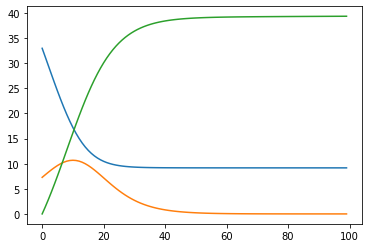

In [66]:
plt.plot(X0.full().T)

In [70]:

W = cs.vertcat(X.reshape((-1,1)), U.T)
W0 = cs.vertcat(X0.reshape((-1,1)), U0)
# prob = {'f': obj, 'x': W, 'g': g}
# solver = cs.nlpsol('solver', 'ipopt', prob)
lbw = [0]*Nx*Nt, [u_min]*Nt
lbw = cs.vertcat(*lbw)
ubx = cs.DM.ones(Nx*Nt)*N_pop
for i in range(Nt):
    ubx[1+3*i] = I_max
ubw = cs.vertcat(ubx, cs.DM.ones(Nt)*u_max)
Ng = g.shape[0]
lbg = cs.DM.zeros(Ng)
ubg = cs.DM.zeros(gx.shape[0])
# sol = solver(x0=cs.vertcat(X0[:], U_mean), lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)
prob = {'f': obj, 'x': W, 'g': g}
solver = cs.nlpsol('solver', 'ipopt', prob)
sol = solver(x0=W0, lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1500
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.8999020e+03 3.93e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

NameError: name 'sol' is not defined

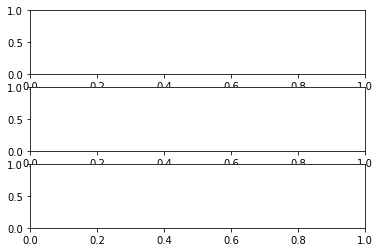

In [12]:
fig, ax = plt.subplots(3)
X_sol = sol['x'][:-Nt].reshape((Nx, Nt))
for i in range(Nx):
    ax[i].plot(X_mean[:,i], color='gray', label='Mean')
    ax[i].plot(X_sol.full()[i,:].T, color='gray', linestyle='dashed', label='Quantile Model')
ax[0].legend()

In [60]:
fig, ax = plot_merged(X_data, U_mean, reg_model)

fig
fig.savefig(CPP_Figure_Dir + 'SIR_merged.png', bbox_inches='tight')
fig.show()

TypeError: plot_merged() missing 1 required positional argument: 'reg_model'

/home/arch/Env/Default/lib/python3.10/site-packages/pysindy/pysindy.py:1194: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


(100, 1600)


/home/arch/Env/Default/lib/python3.10/site-packages/pysindy/pysindy.py:1194: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


(99, 3)


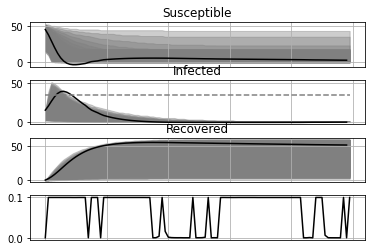

In [72]:
fig, ax = plot_merged(t[:Nt], X_data, sol['x'][-Nt:].full(), reg_model)
ax[1].plot(t[:Nt], [I_max]*Nt, color='gray', linestyle='dashed')

In [56]:
t[:Nt]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]